In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sys

import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed

# Data config
DATA_DIR = "/root/autodl-tmp/COMP9417GroupProject/Data/"
BUFFER = 64
Z_START = 25
Z_DIM = 16
FIXED_HEIGHT = 4096

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
LEARNING_RATE = 1e-4


print("Device: ", DEVICE)
print("Python Version: ", sys.version)
print("PyTorch Version: ", torch.__version__)

"""
This code is written by Zongyuan LANG, z5319088
I was inspired in part by the winners of this Vesuvius Challenge. 
https://www.kaggle.com/code/fchollet/keras-starter-kit-unet-train-on-full-dataset
Note that the original author uses the tensorflow framework, while I use the pytorch framework. And all code is reimplemented and debugged.

For U-net, I partly refer to the following code from github:
https://github.com/qiaofengsheng/pytorch-UNet.git

"""



Device:  cuda
Python Version:  3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
PyTorch Version:  2.0.0+cu118


/root/miniconda3/lib/python3.8/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


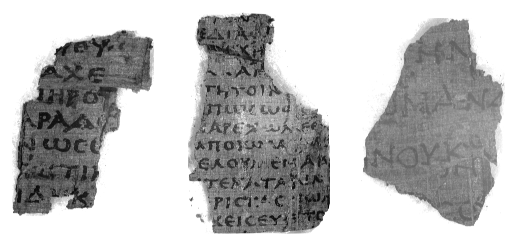

<Figure size 2000x1000 with 0 Axes>

In [32]:
for i in range(1,4):
    plt.subplot(1, 3, i)
    plt.imshow(Image.open(DATA_DIR + "train/" + str(i) + "/ir.png"), cmap='gray')
    plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

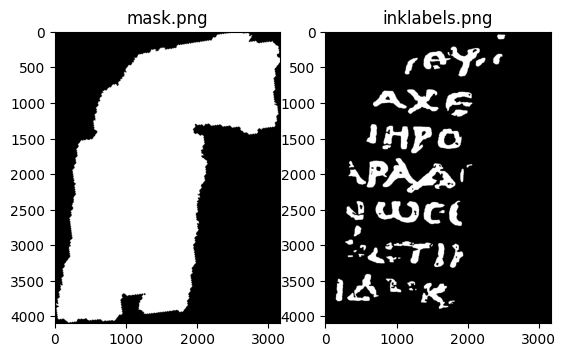

In [33]:
# resize image to fixed height
def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(FIXED_HEIGHT * aspect_ratio)
    new_size = (new_width, FIXED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(dir_1, dir_2):
    mask_img = Image.open(f"{DATA_DIR}{dir_1}/{dir_2}/mask.png").convert("1")
    mask_img = resize(mask_img)
    return torch.tensor(np.array(mask_img), dtype=torch.bool)


def load_labels(dir_1, dir_2):
    label_img = Image.open(f"{DATA_DIR}{dir_1}/{dir_2}/inklabels.png")
    label_img = np.array(resize(label_img))
    return torch.from_numpy(label_img).gt(0)

mask = load_mask("train", "1")
labels = load_labels("train", "1")

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

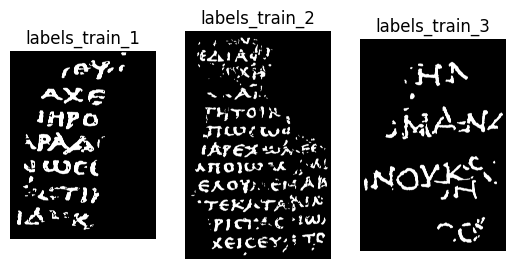

In [35]:
label_image_set = [labels_train_1, labels_train_2, labels_train_3]
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.imshow(label_image_set[i - 1], cmap='gray')
    plt.title(f"labels_train_{i}")
    plt.axis('off')
plt.show()

In [36]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = np.array(resize(img), dtype="float32")
        z_slice = torch.from_numpy(img)
        z_slices.append(z_slice)
        
    return torch.stack(z_slices, dim=0)

In [34]:

# Check the shapes of the masks and labels
mask_test_a = load_mask("test", "a")
mask_test_b = load_mask("test", "b")

mask_train_1 = load_mask("train", 1)
labels_train_1 = load_labels("train", 1)

mask_train_2 = load_mask("train", 2)
labels_train_2 = load_labels("train", 2)

mask_train_3 = load_mask("train", 3)
labels_train_3 = load_labels("train", 3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")



mask_test_a: torch.Size([4096, 9507])
mask_test_b: torch.Size([4096, 4753])
-
mask_train_1: torch.Size([4096, 3169])
labels_train_1: torch.Size([4096, 3169])
-
mask_train_2: torch.Size([4096, 2625])
labels_train_2: torch.Size([4096, 2625])
-
mask_train_3: torch.Size([4096, 2826])
labels_train_3: torch.Size([4096, 2826])


In [37]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = torch.cat([volume_train_1, volume_train_2, volume_train_3], dim=2)
print(f"total volume: {volume.shape}")

del volume_train_1, volume_train_2, volume_train_3

16it [00:02,  6.88it/s]


volume_train_1: torch.Size([16, 4096, 3169]), torch.float32


16it [00:02,  6.35it/s]


volume_train_2: torch.Size([16, 4096, 2625]), torch.float32


16it [00:01,  8.56it/s]


volume_train_3: torch.Size([16, 4096, 2826]), torch.float32
total volume: torch.Size([16, 4096, 8620])


In [38]:
labels = torch.cat([labels_train_1, labels_train_2, labels_train_3], dim=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = torch.cat([mask_train_1, mask_train_2, mask_train_3], dim=1)
print(f"mask: {mask.shape}, {mask.dtype}")

labels: torch.Size([4096, 8620]), torch.bool
mask: torch.Size([4096, 8620]), torch.bool


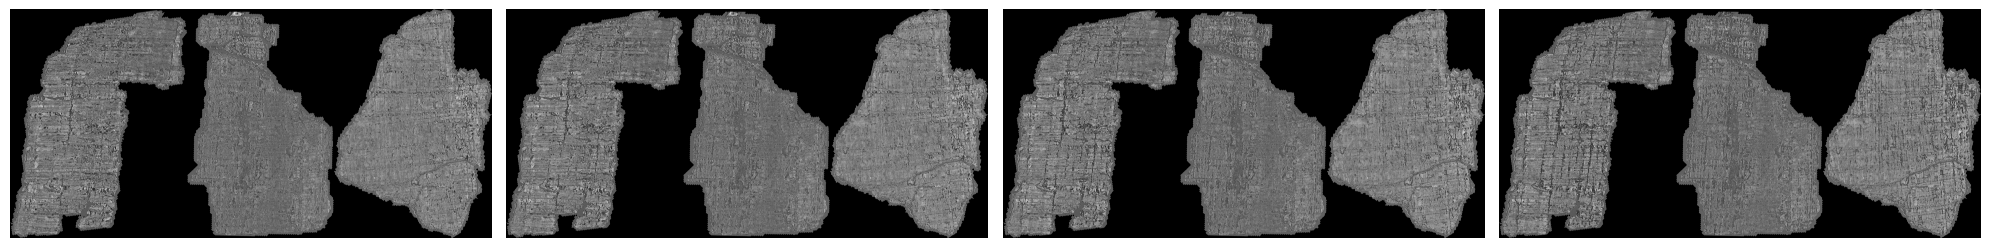

In [39]:
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(volume[i, :, :], cmap='gray')
    plt.gcf().set_size_inches(20, 10)
    plt.axis('off')
plt.tight_layout()
plt.show()

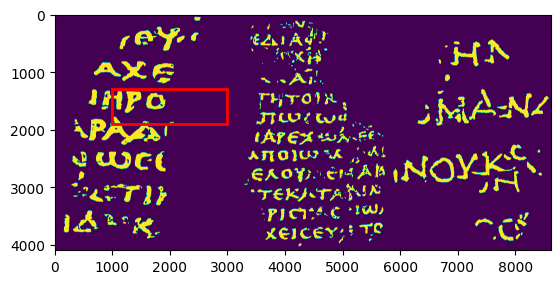

In [40]:
val_location = (1300, 1000)
val_size = (600, 2000)
fig, ax = plt.subplots()
ax.imshow(labels.cpu())
patch = patches.Rectangle((val_location[1], val_location[0]), val_size[1], val_size[0], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

In [41]:
def sample_random_location(shape):
    random_train_x = torch.randint(low=BUFFER, high=shape[0] - BUFFER - 1, size=(1,))
    random_train_y = torch.randint(low=BUFFER, high=shape[1] - BUFFER - 1, size=(1,))
    random_train_location = torch.cat([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_size) and is_in_mask_train(location)
    

In [42]:

from torch.utils.data import Dataset

class LocationDataset(Dataset):
    def __init__(self, mask, val_location, val_zone_size, BUFFER):
        self.mask = mask
        self.val_location = val_location
        self.val_zone_size = val_zone_size
        self.BUFFER = BUFFER

    def __len__(self):
        # Return the number of samples you want to generate
        return 1280

    def __getitem__(self, index):
        # Generate a random location
        loc = self.sample_random_location(self.mask.shape)
        while not self.is_proper_train_location(loc):
            loc = self.sample_random_location(self.mask.shape)
        return loc

    def sample_random_location(self, shape):
        random_train_x = torch.randint(low=self.BUFFER, high=shape[0] - self.BUFFER - 1, size=(1,))
        random_train_y = torch.randint(low=self.BUFFER, high=shape[1] - self.BUFFER - 1, size=(1,))
        random_train_location = torch.cat([random_train_x, random_train_y])
        return random_train_location

    def is_in_masked_zone(self, location):
        return self.mask[location[0].item(), location[1].item()]

    def is_in_val_zone(self, location):
        x = location[0].item()
        y = location[1].item()
        x_match = self.val_location[0] - self.BUFFER <= x <= self.val_location[0] + self.val_zone_size[0] + self.BUFFER
        y_match = self.val_location[1] - self.BUFFER <= y <= self.val_location[1] + self.val_zone_size[1] + self.BUFFER
        return x_match and y_match

    def is_proper_train_location(self, location):
        return not self.is_in_val_zone(location) and self.is_in_masked_zone(location)

dataset = LocationDataset(mask, val_location, val_size, BUFFER)



In [43]:
train_locations_ds = LocationDataset(mask, val_location, val_size, BUFFER)
train_locations_loader = data.DataLoader(train_locations_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [44]:
len(train_locations_ds)

1280

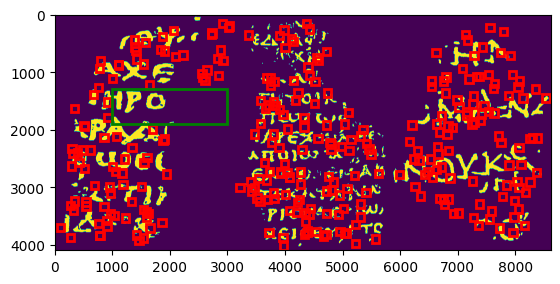

In [45]:

fig, ax = plt.subplots()
ax.imshow(labels)

for i,(x, y) in enumerate(train_locations_ds):
    if i > 300:
        break
    
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_size[1], val_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [46]:
from torch.utils.data import Dataset

def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[:,x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    subvolume = subvolume.to(torch.float32) / 65535.
    return subvolume

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    a = label.unsqueeze(dim=0)
    return a

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

class CustomDataset(Dataset):
    def __init__(self, train_locations_ds, volume, labels):
        self.train_locations_ds = train_locations_ds
        self.volume = volume
        self.labels = labels
        self.n = 0

    def __len__(self):
        return len(self.train_locations_ds)
 

    def __getitem__(self, index):
        location = self.train_locations_ds[index]
        subvolume = extract_subvolume(location, volume)
        label = extract_labels(location, labels)

        return subvolume, label

In [47]:
train_ds = CustomDataset(train_locations_ds, volume, labels)
train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [48]:
import time
t0 = time.time()
n = 200
for _ in enumerate(train_loader):
    pass
print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

Time per batch: 0.0065s


In [49]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_size[1], val_locations_stride):
        val_locations.append((x, y))

class ValidationDataset(Dataset):
    def __init__(self, val_locations, mask, val_zone_size):
        self.val_locations = val_locations
        self.mask = mask
        self.val_zone_size = val_zone_size

    def __len__(self):
        return len(self.val_locations)

    def __getitem__(self, index):
        location = self.val_locations[index]
        subvolume = extract_subvolume(location, volume)  # Implement the extract_subvolume function
        label = extract_labels(location, labels)  # Implement the extract_labels function
        return subvolume, label

In [50]:
val_dataset = ValidationDataset(val_locations, mask, val_size)
val_loader = data.DataLoader(val_dataset,  batch_size = BATCH_SIZE, shuffle=True)

In [51]:
for subvolume, label in val_loader:
    print(f"subvolume: {subvolume.shape}, {subvolume.dtype}")
    print(f"label: {label.shape}, {label.dtype}")
    break

subvolume: torch.Size([32, 16, 128, 128]), torch.float32
label: torch.Size([32, 1, 128, 128]), torch.bool


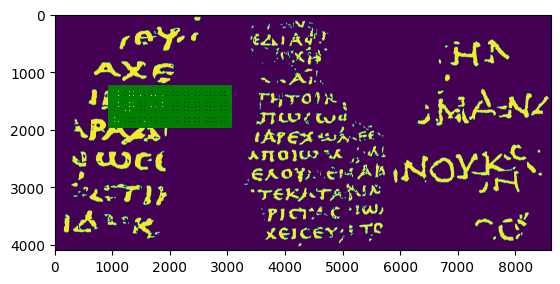

In [52]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

In [53]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        # Assuming the batch_label is of shape [batch_size, 64, 64, 1]
        batch_label = batch_label.squeeze(0)  # Remove the first dimension (batch size)
        matches += torch.sum(batch_label)
        total += torch.prod(torch.tensor(batch_label.shape))

    return 1. - matches / total

score = trivial_baseline(val_loader).item()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

100%|██████████| 10/10 [00:00<00:00, 80.86it/s]

Best validation score achievable trivially: 87.50% accuracy


In [54]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)
class UNet(nn.Module):
    def __init__(self, in_ch, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(in_ch, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)

        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)

        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x


In [55]:
class AverageMeter(object):
    def __init__(self):
        self.sum = 0
        self.n = 0

    def update(self, x, n=1):
        self.sum += float(x)
        self.n += n

    def reset(self):
        self.sum = 0
        self.n = 0

    def get_value(self):
        if self.n:
            return self.sum / self.n
        return 0

In [17]:
print("=====> Begin training")
meter = AverageMeter()
net = UNet(in_ch=Z_DIM, out_classes=1, up_sample_mode='conv_transpose').to(DEVICE)
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
best_val_loss = 100
best_val_acc = 0
net.train()
for epoch in range(30):
    bar = tqdm(enumerate(train_loader), total = 1280 / BATCH_SIZE)
    bar.set_description_str(f"Epoch: {epoch}")
    for i, (train_subvolume, train_label) in bar:
        subvolume = train_subvolume.to(DEVICE)
        label = train_label.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(subvolume)
        loss = criterion(outputs, label.float())
        loss.backward()
        optimizer.step()
        meter.update(loss)
        bar.set_postfix_str(f"Avg loss: {np.round(meter.get_value(),3)}")

    meter_loss =AverageMeter()
    meter_acc = AverageMeter()
    net.eval()
    val_loss = 0
    val_acc = 0
    for _, (val_subvolume, val_label) in enumerate(val_loader):
        val_subvolume = val_subvolume.to(DEVICE)
        val_label = val_label.to(DEVICE)
        val_outputs = net(val_subvolume)
        loss = criterion(val_outputs, val_label.float())
        meter_loss.update(loss)
        pred = torch.sigmoid(val_outputs) > 0.5
        meter_acc.update((pred == val_label.to(DEVICE)).sum(), int(torch.prod(torch.tensor(val_label.shape))))
        net.train()
    val_loss = np.round(meter_loss.get_value(),3)
    val_acc = np.round(meter_acc.get_value(),3)

        
    print(f"======> Val Loss:{val_loss} | Val Acc:{val_acc} ")
    if epoch == 19:
        torch.save(net.state_dict(), "/root/autodl-tmp/COMP9417GroupProject/param/UNet_Best.pt")
        print("======> Save best val model")
    


=====> Begin training


Epoch: 0: 100%|██████████| 20/20.0 [00:54<00:00,  2.75s/it, Avg loss: 0.587]


======> Val Loss:0.593 | Val Acc:0.814 
======> Save best val model


Epoch: 1: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.546]


======> Val Loss:0.504 | Val Acc:0.814 


Epoch: 2: 100%|██████████| 20/20.0 [00:17<00:00,  1.14it/s, Avg loss: 0.523]


======> Val Loss:0.477 | Val Acc:0.813 


Epoch: 3: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.509]


======> Val Loss:0.494 | Val Acc:0.809 


Epoch: 4: 100%|██████████| 20/20.0 [00:18<00:00,  1.09it/s, Avg loss: 0.496]


======> Val Loss:0.711 | Val Acc:0.734 


Epoch: 5: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.486]


======> Val Loss:0.454 | Val Acc:0.811 


Epoch: 6: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.476]


======> Val Loss:0.464 | Val Acc:0.814 
======> Save best val model


Epoch: 7: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.469]


======> Val Loss:0.505 | Val Acc:0.795 


Epoch: 8: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.463]


======> Val Loss:0.955 | Val Acc:0.609 


Epoch: 9: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.457]


======> Val Loss:0.543 | Val Acc:0.68 


Epoch: 10: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.451]


======> Val Loss:0.525 | Val Acc:0.67 


Epoch: 11: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.446]


======> Val Loss:0.455 | Val Acc:0.815 
======> Save best val model


Epoch: 12: 100%|██████████| 20/20.0 [00:18<00:00,  1.10it/s, Avg loss: 0.441]


======> Val Loss:0.424 | Val Acc:0.812 


Epoch: 13: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.436]


======> Val Loss:0.457 | Val Acc:0.794 


Epoch: 14: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.431]


======> Val Loss:0.487 | Val Acc:0.756 


Epoch: 15: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.427]


======> Val Loss:0.464 | Val Acc:0.819 


Epoch: 16: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.422]


======> Val Loss:0.668 | Val Acc:0.646 


Epoch: 17: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.418]


======> Val Loss:2.301 | Val Acc:0.511 


Epoch: 18: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.414]


======> Val Loss:0.447 | Val Acc:0.83 
======> Save best val model


Epoch: 19: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.41] 


======> Val Loss:0.415 | Val Acc:0.821 


Epoch: 20: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.407]


======> Val Loss:0.425 | Val Acc:0.829 


Epoch: 21: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.402]


======> Val Loss:0.413 | Val Acc:0.83 


Epoch: 22: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.399]


======> Val Loss:0.406 | Val Acc:0.829 


Epoch: 23: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.397]


======> Val Loss:0.435 | Val Acc:0.812 


Epoch: 24: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.394]


======> Val Loss:0.477 | Val Acc:0.781 


Epoch: 25: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.391]


======> Val Loss:0.565 | Val Acc:0.714 


Epoch: 26: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.388]


======> Val Loss:0.444 | Val Acc:0.808 


Epoch: 27: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.385]


======> Val Loss:0.409 | Val Acc:0.833 
======> Save best val model


Epoch: 28: 100%|██████████| 20/20.0 [00:17<00:00,  1.13it/s, Avg loss: 0.382]


======> Val Loss:1.104 | Val Acc:0.523 


Epoch: 29: 100%|██████████| 20/20.0 [00:17<00:00,  1.12it/s, Avg loss: 0.38] 


======> Val Loss:0.828 | Val Acc:0.63 


In [18]:
# Load the best model
criterion = nn.BCEWithLogitsLoss(reduction='mean')
net.load_state_dict(torch.load("/root/autodl-tmp/COMP9417GroupProject/param/unet.pth"))
net.criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
meter_loss =AverageMeter()
meter_acc = AverageMeter()
net.eval()
val_loss = 0
val_acc = 0
for _, (val_subvolume, val_label) in enumerate(val_loader):
    val_subvolume = val_subvolume.to(DEVICE)
    val_label = val_label.to(DEVICE)
    val_outputs = net(val_subvolume)
    loss = criterion(val_outputs, val_label.float())
    meter_loss.update(loss)
    pred = torch.sigmoid(val_outputs) > 0.5
    meter_acc.update((pred == val_label.to(DEVICE)).sum(), int(torch.prod(torch.tensor(val_label.shape))))
    net.train()
val_loss = np.round(meter_loss.get_value(),3)
val_acc = np.round(meter_acc.get_value(),3)

net.eval()
print(f"Val loss: {val_loss} | Val acc: {val_acc}")

Val loss: 0.409 | Val acc: 0.833


In [19]:
from tqdm import tqdm
def compute_predictions_map(split, index):
    print(f"======> Load data for {split}/{index}")
    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)
    print(f"======> Volume shape: {test_volume.shape}")
    test_locations = []
    stride = BUFFER // 2

    for x in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[2] - BUFFER, stride):
            if is_in_masked_zone([torch.tensor(x),torch.tensor(y)], test_mask):
                test_locations.append((x, y))
    print(f"======> {len(test_locations)} test locations (after filtering by mask)")

    predictions_map = torch.zeros((1, 1, test_volume.shape[1], test_volume.shape[2]))
    predictions_map_counts = torch.zeros((1, 1, test_volume.shape[1], test_volume.shape[2]))
    print(f"======> Compute predictions")

    with torch.no_grad():
        bar = tqdm(test_locations)
        for loc in bar:
            subvolume, label = get_subvolume([loc], test_volume, None)
            outputs = net(subvolume.to(DEVICE))
            pred = torch.sigmoid(outputs)
            # print(loc, (pred > 0.5).sum())
            # Here a single location may be with multiple result
            predictions_map[:, :, loc[0] - BUFFER : loc[0] + BUFFER, loc[1] - BUFFER : loc[1] + BUFFER] += pred.cpu()
            predictions_map_counts[:, :, loc[0] - BUFFER : loc[0] + BUFFER, loc[1] - BUFFER : loc[1] + BUFFER] += 1
    # print(predictions_map_b[:,:, 2500, 1000])
    # print(predictions_map_counts[:,:, 2500, 1000])
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map

In [20]:
predictions_map_a = compute_predictions_map(split="test", index="a")
predictions_map_b = compute_predictions_map(split="test", index="b")

======> Load data for test/a


16it [00:07,  2.05it/s]


======> Volume shape: torch.Size([16, 4096, 9507])
======> 23391 test locations (after filtering by mask)
======> Compute predictions


100%|██████████| 23391/23391 [03:15<00:00, 119.56it/s]


======> Load data for test/b


16it [00:03,  4.41it/s]


======> Volume shape: torch.Size([16, 4096, 4753])
======> 9951 test locations (after filtering by mask)
======> Compute predictions


100%|██████████| 9951/9951 [01:24<00:00, 117.73it/s]


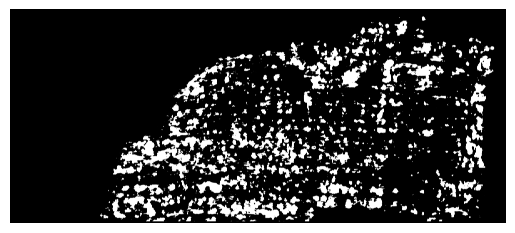

In [21]:
import matplotlib.pyplot as plt
# Threshold is very important !!!!!
plt.imshow(predictions_map_a.squeeze() > 0.15, cmap='gray')
plt.axis("off")
plt.savefig("UNet_predictions_map_a.png")

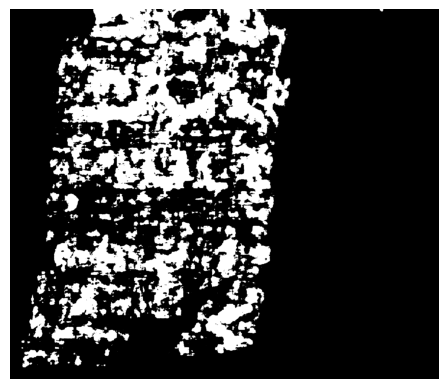

In [22]:
plt.imshow(predictions_map_b.squeeze() > 0.15, cmap='gray')
plt.axis("off")
plt.savefig("Unet_predictions_map_b.png")

In [25]:
pred = compute_predictions_map(split="train", index="1")

======> Load data for train/1


16it [00:02,  6.91it/s]


======> Volume shape: torch.Size([16, 4096, 3169])
======> 7097 test locations (after filtering by mask)
======> Compute predictions


100%|██████████| 7097/7097 [00:59<00:00, 119.55it/s]


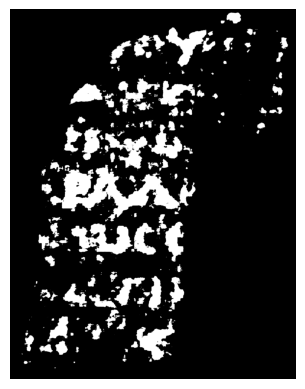

In [26]:
plt.imshow(pred.squeeze() > 0.2, cmap='gray')
plt.axis("off")
plt.savefig("Unet_predictions_map_1.png")

In [27]:
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return c_recall, c_precision, dice

In [30]:
targets = np.array(resize(Image.open("Data/train/1/inklabels.png")))
reshaped_pred = pred.squeeze()

c_recall, c_precision, dice = fbeta_score(reshaped_pred, targets, 0.2)
print(f"c_recall: {c_recall}")
print(f"c_precision: {c_precision}")
print(f"fbeta_score: {dice}")

c_recall: 0.7711339592933655
c_precision: 0.6003973484039307
fbeta_score: 0.6282091736793518
